In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns



df = pd.read_csv("upwork_jobs.csv")
#pd.set_option('display.max_columns', None) # Colab'da görüntüleme yaparken tüm sütunları göstermek.

df.head()

,Job Title,Hourly/Fixed,Budget,Level,Skills
0,Flutter Web Dev,Hourly,NaN,Intermediate,"Web Development, Flutter"
1,iOS / Android Internal Work Order Application,Hourly,NaN,Intermediate,"Mobile App Development, iOS, Android"
2,WordPress Designer For Case Study Pages (Exist...,Hourly,NaN,Expert,"Web Development, WordPress, Graphic Design, We..."
3,Software Architect / Technical Lead (Node.js E...,Hourly: $25.00 - $35.00,NaN,Intermediate,"TypeScript, NestJS, Next.js, Node.js, JavaScri..."
4,Shopify Integration Specialist Needed for 3PL ...,Hourly: $25.00 - $50.00,NaN,Expert,"Ecommerce Website Development, Web Development..."


In [3]:
"""
Veri çekerken site 100.sayfadan sonra ilerlemeye izin vermediği için veri tekrarları var burada onları kaldırdım.
"""
df = df.drop_duplicates()

print(f'Satır Sayısı: {df.shape[0]}\n')


"""
String olan Job Title sütununu kaldırdım.
"""
df = df.drop(columns=['Job Title'])


"""
Skills sütununun sonunda +1 gibi değerleri kaldırmak için regex ile bu ifadeleri yakalayıp sildim.
"""
df['Skills'] = df['Skills'].str.replace(r', \+\d+', '', regex=True)


"""
Alttaki all_skills bulma adımında hata aldıktan sonra bu kontrolü gerçekleştirdim. Bazı verilerin float olduğunu gördüm. Alttaki satırda
float_rows'ları görüntülediğimde bunun nedeninin NaN değerler olduğunu gördüm ve bunları kaldırdım.
Bunun nedeni NaN değerler olması ve bunlar float olarak algılaması..
"""

print(df['Skills'].apply(type).value_counts())
float_rows = df[df['Skills'].apply(lambda x: isinstance(x, float))]
print(float_rows)

df['Skills'] = df['Skills'].dropna()

Satır Sayısı: 5051

Skills
<class 'str'>      4990
<class 'float'>      61
Name: count, dtype: int64
                  Hourly/Fixed                 Budget         Level Skills
66     Hourly: $25.00 - $47.00                    NaN        Expert    NaN
200                     Hourly                    NaN        Expert    NaN
383                     Hourly                    NaN        Expert    NaN
444                Fixed price  Est. budget:\n$300.00        Expert    NaN
467                Fixed price  Est. budget:\n$250.00  Intermediate    NaN
...                        ...                    ...           ...    ...
6200               Fixed price  Est. budget:\n$550.00        Expert    NaN
8050   Hourly: $15.00 - $35.00                    NaN  Intermediate    NaN
15950              Fixed price  Est. budget:\n$250.00  Intermediate    NaN
17250              Fixed price  Est. budget:\n$250.00  Intermediate    NaN
17950              Fixed price  Est. budget:\n$250.00  Intermediate    NaN

In [4]:
"""
Bu aşamada yeteneklerin hepsini skills sütunundan çektikten sonra bunların sayılarını hesapladım. Bunları csv dosyasına aktardım ve sıraladım.
"""
all_skills = df['Skills'].str.split(',').explode().str.strip()
top_200_skills = all_skills.value_counts().head(200).index.to_numpy()

#all_skills.value_counts().to_csv("skills_count.csv")


"""
Direkt olarak get_dummies(sep=", ") özelliğini kullanarak skills sütununda bulunan yeteneklerle one-hot encoding ile sütunlar oluşturdum
"""
encoded_skills = df["Skills"].str.get_dummies(sep=", ")

encoded_skills.head()

,.NET Core,.NET Framework,360-Degree Photography,3D Animation,3D Design,3D Model,3D Modeling,3D Rendering,A-Parser,A/B Testing,...,iPad App Development,iPadOS,jQuery,jQuery UI,macOS,n8n,pandas,phpFox,tvOS,web3.js
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
"""
Encoding yapılmış yeteneklerin toplamını bulup en çok kullanılanlardan 200 tanesini seçtim. Ve orjinal Skills sütununu kaldırdım.
"""

filtered_encoded_skills = encoded_skills[top_200_skills]

filtered_encoded_skills.head()

df = pd.concat([df, filtered_encoded_skills], axis=1)

df = df.drop(columns=['Skills'])

df.head()

,Hourly/Fixed,Budget,Level,Web Development,JavaScript,Web Design,WordPress,HTML,PHP,CSS,...,Style Guide,Data Science,ChatGPT API Integration,SEO Keyword Research,Zoho CRM,Product Management,Google Chrome Extension,Windows App Development,Web Scraping,Microsoft SQL Server
0,Hourly,NaN,Intermediate,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hourly,NaN,Intermediate,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hourly,NaN,Expert,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hourly: $25.00 - $35.00,NaN,Intermediate,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hourly: $25.00 - $50.00,NaN,Expert,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
"""
Hourly/Fixed sütununda bazı veriler "Hourly: $25.00 - $35.00" şeklindeydi buradan bu sayısal değerleri yakaladım ve ortalamasını döndürdüm.
Budget sütununda ise bazı veriler "Est. budget: $150.00" şeklindeydi. Buradan da sayısal değeri yakaladım.
Hourly/Fixed sütunu artık saatlik ücretleri tuttuğu için ismini Hourly olarak değiştirdim.
Budget sütunu artık sabit ücretleri tuttuğu için ismini Fixed olarak değiştirdim.
"""
def extract_hourly_rate(value):
    match = re.match(r'Hourly: \$(\d+\.\d+) - \$(\d+\.\d+)', value)
    if match:
        low = float(match.group(1))
        high = float(match.group(2))
        return (low + high) / 2
    return None


df['Hourly/Fixed'] = df['Hourly/Fixed'].apply(extract_hourly_rate)
df.rename(columns={'Hourly/Fixed': 'Hourly'}, inplace=True)

df['Budget'] = df['Budget'].str.extract(r'\$(\d+\.\d+)')
df.rename(columns={'Budget': 'Fixed'}, inplace=True)

df.head(10)

,Hourly,Fixed,Level,Web Development,JavaScript,Web Design,WordPress,HTML,PHP,CSS,...,Style Guide,Data Science,ChatGPT API Integration,SEO Keyword Research,Zoho CRM,Product Management,Google Chrome Extension,Windows App Development,Web Scraping,Microsoft SQL Server
0,NaN,NaN,Intermediate,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,Intermediate,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,Expert,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30.0,NaN,Intermediate,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37.5,NaN,Expert,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,18.00,Intermediate,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,NaN,Expert,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,150.00,Intermediate,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4.0,NaN,Intermediate,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,NaN,150.00,Intermediate,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
"""
Hourly ve Fixed sütunlardan her ikisi de null olan değerleri filtreledim ve bu satırları kaldırdım.
"""
both_null_rows = df[df['Hourly'].isnull() & df['Fixed'].isnull()]

both_null_count = both_null_rows.shape[0]
print(f"İki sütunda da NaN olan satırların sayısı: {both_null_count}")

df_cleaned = df.drop(both_null_rows.index)

print(f"Temizlenmiş DataFrame'deki satır sayısı: {df_cleaned.shape[0]}")

İki sütunda da NaN olan satırların sayısı: 1445
Temizlenmiş DataFrame'deki satır sayısı: 3606


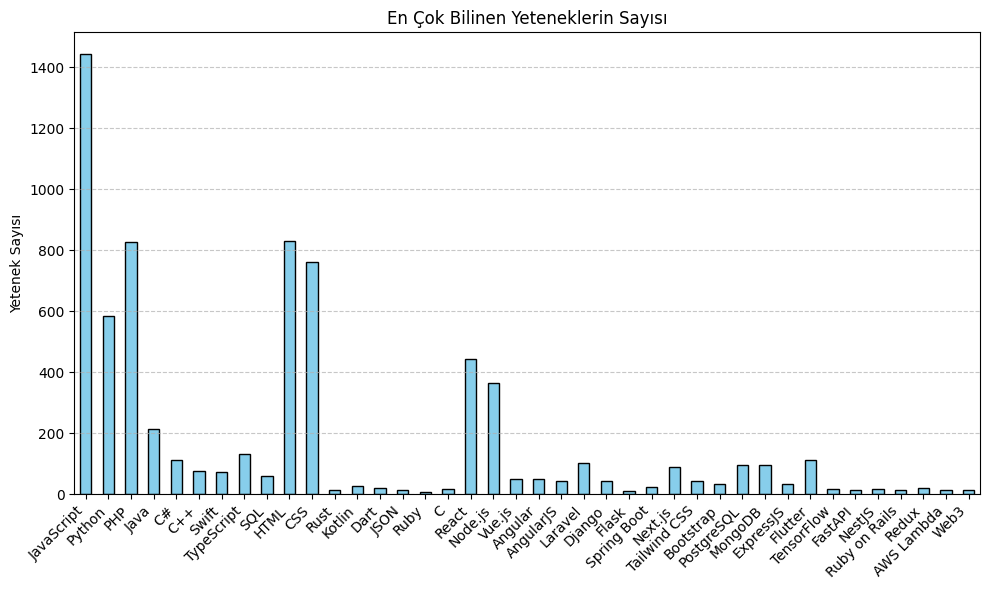

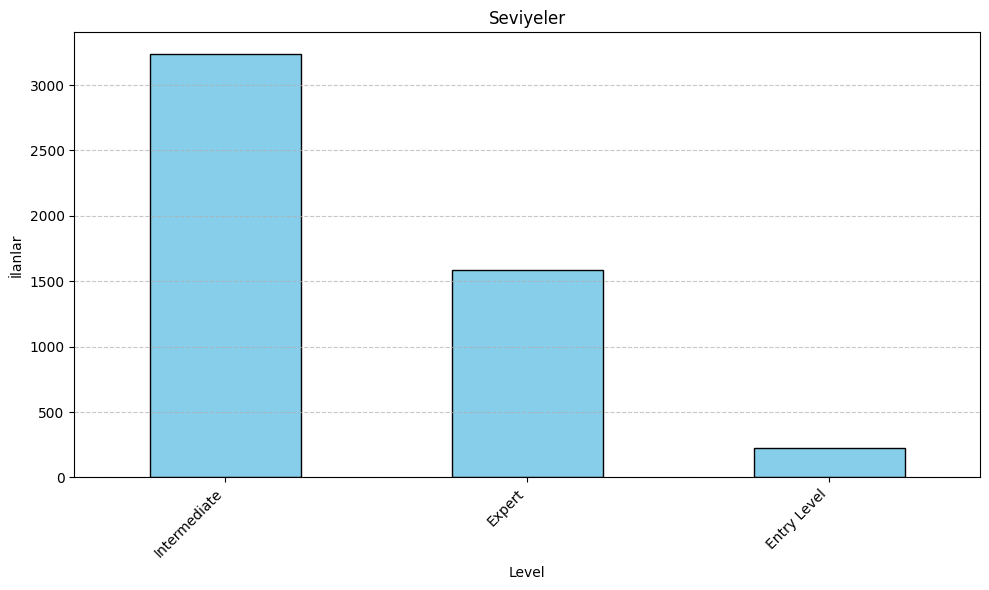

In [14]:
"""
Dataframe'deki yeteneklerden yazılım dillerini/frameworklerini çıkardım ve toplamlarını bar grafiği ile gösterdim.
"""
techs = ["JavaScript", "Python", "PHP", "Java", "C#", "C++", "Swift", "TypeScript", "SQL", "HTML", "CSS", "Rust", "Kotlin", "Dart",
            "JSON", "Ruby", "C", "React", "Node.js", "Vue.js", "Angular", "AngularJS", "Laravel", "Django", "Flask",
            "Spring Boot", "Next.js", "Tailwind CSS", "Bootstrap", "PostgreSQL", "MongoDB", "ExpressJS", "Flutter", "TensorFlow",
            "FastAPI", "NestJS", "Ruby on Rails", "Redux", "AWS Lambda", "Web3"]


# One-hot encoding yapılan sütunların toplamlarını hesapla
feature_sums = encoded_skills[techs].sum(axis=0)

# Çubuk grafiği oluştur
plt.figure(figsize=(10, 6))
feature_sums.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('En Çok Bilinen Yeteneklerin Sayısı')
plt.ylabel('Yetenek Sayısı')
plt.xticks(rotation=45, ha='right')  # X ekseni yazılarını döndür
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


"""
Dataframe'deki seviyelerin sayılarını bar grafiği ile gösterdim.
"""
feature_sums = df['Level'].value_counts()

# Çubuk grafiği oluştur
plt.figure(figsize=(10, 6))
feature_sums.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Seviyeler')
plt.ylabel('İlanlar')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

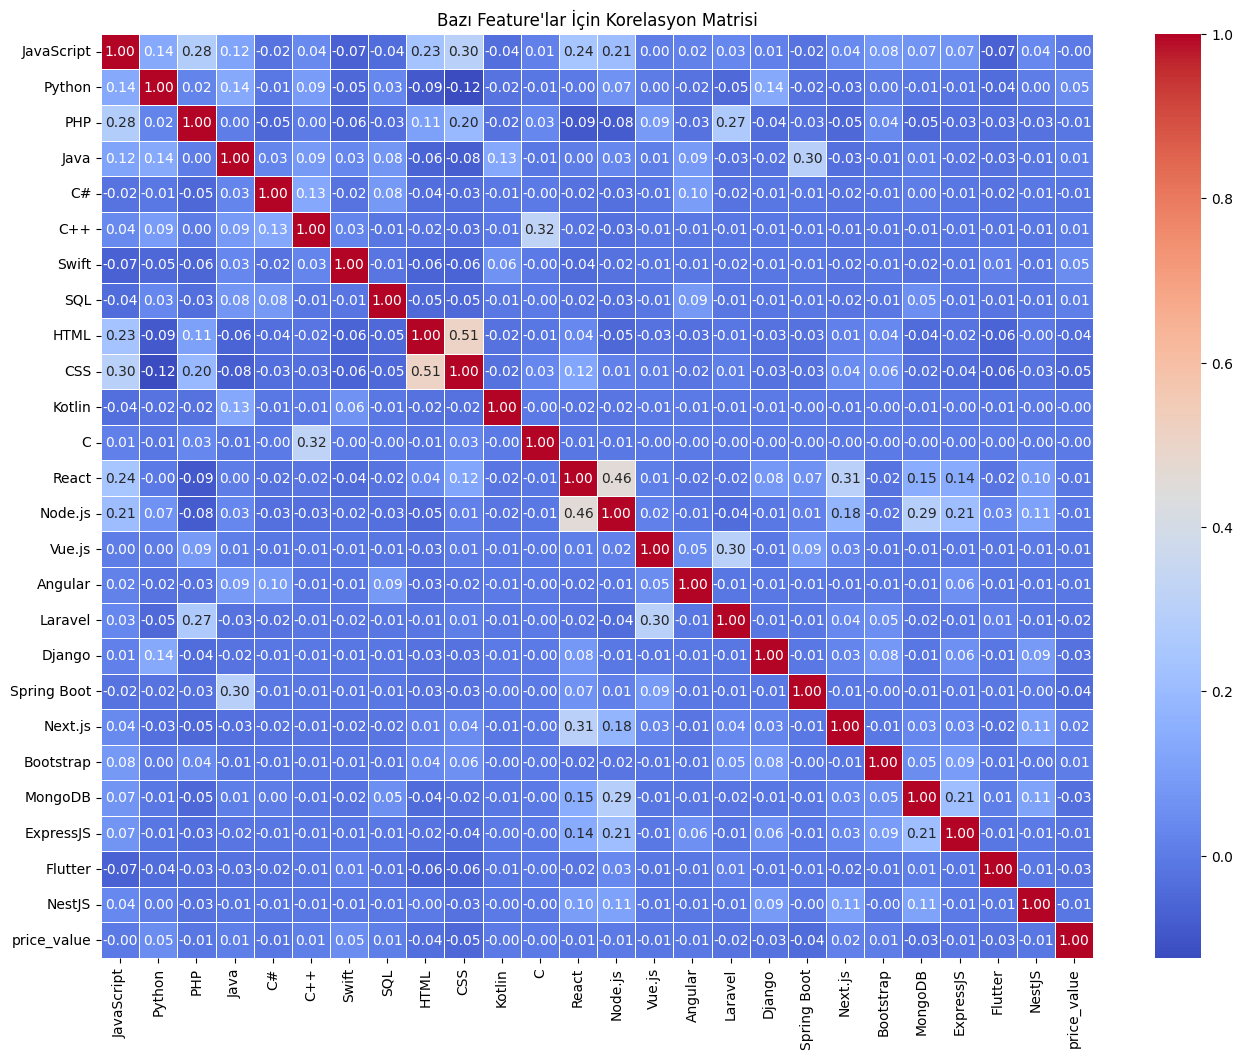

In [20]:

"""
Dataframe'de satırlarda hourly ve fixed değerlerden yalnızca biri bulunuyor.
Bunları ayrı ayrı tahmin etmek için ayrı dataframe'ler oluşturdum.
"""
hourly_df = df[df['Hourly'].notnull()].copy()
fixed_df = df[df['Fixed'].notnull()].copy()

# Fiyat sütunlarını belirleme
hourly_df['price_value'] = hourly_df['Hourly']
fixed_df['price_value'] = fixed_df['Fixed']

# Hourly ve Fixed Price sütunlarını kaldırıyoruz
hourly_df.drop(['Hourly', 'Fixed'], axis=1, inplace=True)
fixed_df.drop(['Hourly', 'Fixed'], axis=1, inplace=True)

#hourly_df.to_csv("hourly_jobs.csv", index=False)
#fixed_df.to_csv("fixed_jobs.csv", index=False)


"""
price_value değerleri string olduğu için bunları işlem yapabilmek için float değerlere çevirdim.
"""
#print(fixed_df['price_value'].dtype)

fixed_df['price_value'] = pd.to_numeric(fixed_df['price_value'], errors='coerce')
hourly_df['price_value'] = pd.to_numeric(hourly_df['price_value'], errors='coerce')


corr_matrix_hourly = hourly_df[["JavaScript", "Python", "PHP", "Java", "C#", "C++", "Swift", "SQL", "HTML", "CSS", "Kotlin",
              "C", "React", "Node.js", "Vue.js", "Angular", "Laravel", "Django",
            "Spring Boot", "Next.js", "Bootstrap","MongoDB", "ExpressJS", "Flutter",
             "NestJS", "price_value"]].corr()

# Korelasyon matrisini görselleştir
plt.figure(figsize=(16, 12))  # Görselleştirme boyutunu ayarlayın
sns.heatmap(corr_matrix_hourly, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Bazı Feature'lar İçin Korelasyon Matrisi")
plt.show()

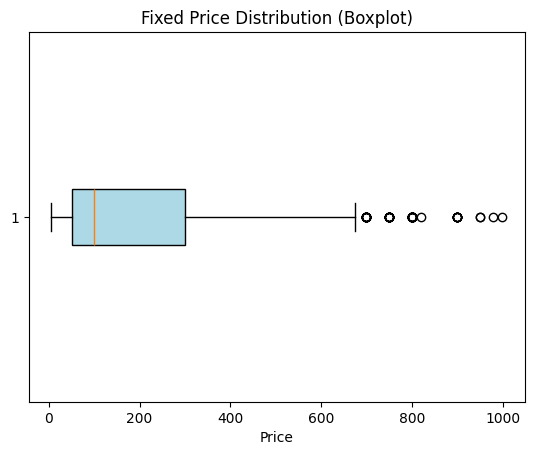

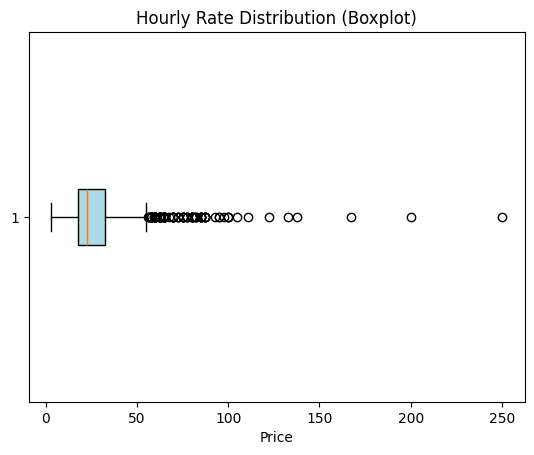

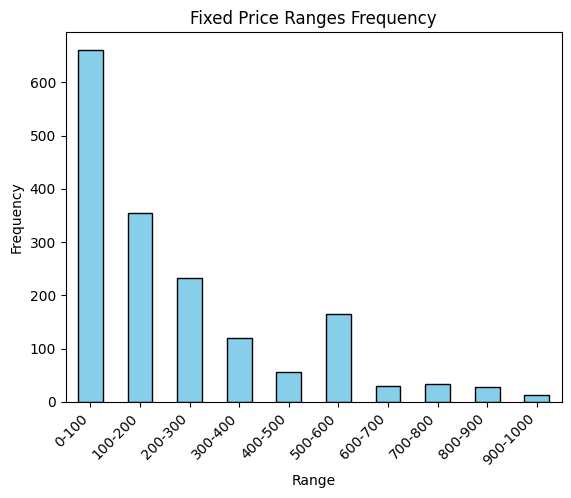

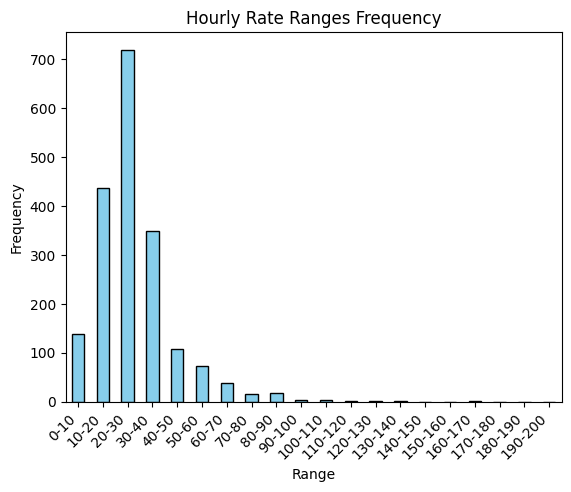

In [21]:

"""
Boxplot üzerinde saatlik ve sabit ücretlerin dağılımını boxplot ile gösterdim.
Bu sayede min, max değerleri ve aykırı değerleri görüntüleyebildim.
"""
plt.boxplot(fixed_df['price_value'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Fixed Price Distribution (Boxplot)')
plt.xlabel('Price')
plt.show()

plt.boxplot(hourly_df['price_value'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Hourly Rate Distribution (Boxplot)')
plt.xlabel('Price')
plt.show()


"""
Boxplot dışında bar grafiğinde aralıklarla ücret değerlerini gösterdim.
"""
bins = list(range(0, 1001, 100)) # 0'dan 1000'e kadar 100'er 100'er artan aralıklar

labels = [f"{i}-{i+100}" for i in range(0, 901, 100)] #0-100 100-200 şeklinde labeller oluşturdum.

range_counts = pd.cut(fixed_df['price_value'], bins=bins, labels=labels, right=False).value_counts().sort_index()

# Grafik oluşturma
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Fixed Price Ranges Frequency')
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right') # X eksenindeki etiketlerin daha rahat görünmesi için çapraz şekilde yerleştirdim.
plt.show()

bins = list(range(0, 210, 10))

labels = [f"{i}-{i+10}" for i in range(0, 200, 10)]

range_counts = pd.cut(hourly_df['price_value'], bins=bins, labels=labels, right=False).value_counts().sort_index()

# Grafik oluşturma
range_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Hourly Rate Ranges Frequency')
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Aralık Sınırları (bins): [0, 15, 50, inf]
Aralık Sınırları (bins): [  4.33       228.33333333 451.66666667 675.        ]

FIXED PRICE PERFORMANCE METRICS:
----------------------------------------
Model: Logistic Regression
-----------------------------
Accuracy for Logistic Regression: 0.56
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       Düşük       0.67      0.61      0.64       250
        Orta       0.48      0.38      0.42       237
      Yüksek       0.52      0.67      0.59       248

    accuracy                           0.56       735
   macro avg       0.56      0.55      0.55       735
weighted avg       0.56      0.56      0.55       735



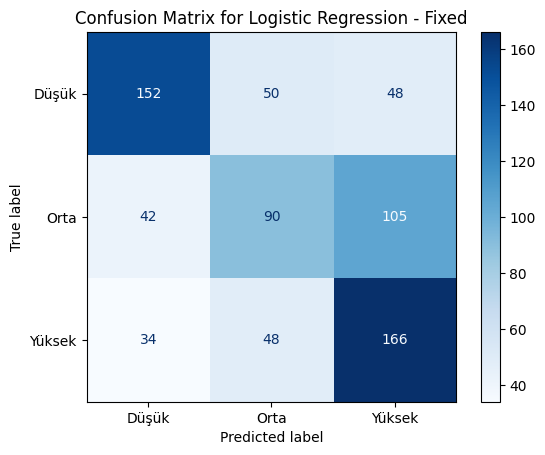


--------------------------------------------------

Model: Support Vector Machine
-----------------------------
Accuracy for Support Vector Machine: 0.54
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

       Düşük       0.66      0.52      0.58       250
        Orta       0.48      0.32      0.39       237
      Yüksek       0.50      0.75      0.60       248

    accuracy                           0.54       735
   macro avg       0.54      0.53      0.52       735
weighted avg       0.55      0.54      0.52       735



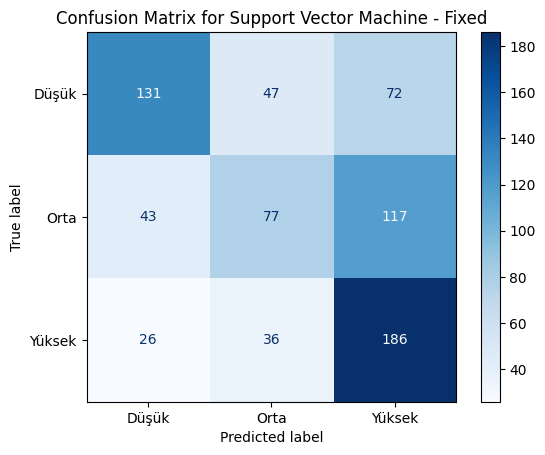


--------------------------------------------------

Model: Random Forest
-----------------------------
Accuracy for Random Forest: 0.64
Classification Report for Random Forest:
              precision    recall  f1-score   support

       Düşük       0.70      0.60      0.65       250
        Orta       0.56      0.71      0.63       237
      Yüksek       0.68      0.61      0.64       248

    accuracy                           0.64       735
   macro avg       0.65      0.64      0.64       735
weighted avg       0.65      0.64      0.64       735



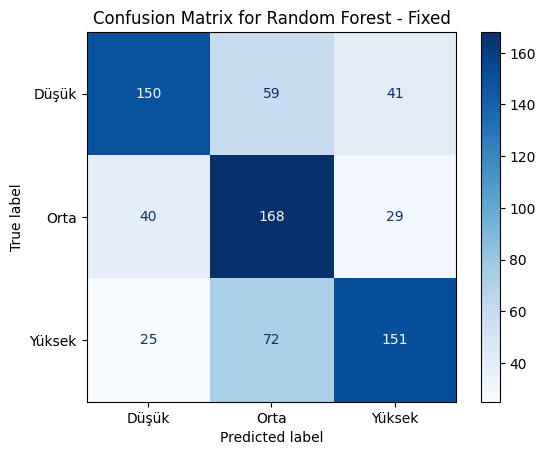


--------------------------------------------------



In [183]:
"""
Aykırı değerleri ortalama değerle değiştirdim.
Bunun için Q1(ilk çeyrek) ve Q3(üçüncü çeyrek) değerini bularak IQR değerini hesapladım.
Sonra formülü kullanarak alt sınır ve üst sınırı belirledim.
"""

Q1_fixed = fixed_df['price_value'].quantile(0.25)
Q3_fixed = fixed_df['price_value'].quantile(0.75)
IQR = Q3_fixed - Q1_fixed

lower_bound = Q1_fixed - 1.5 * IQR
upper_bound = Q3_fixed + 1.5 * IQR

mean_value = fixed_df['price_value'].mean()
fixed_df['price_value'] = fixed_df['price_value'].apply(lambda x: mean_value if (x < lower_bound or x > upper_bound) else x)


Q1_hourly = hourly_df['price_value'].quantile(0.25)
Q3_hourly = hourly_df['price_value'].quantile(0.75)
IQR = Q3_hourly - Q1_hourly

lower_bound = Q1_hourly - 1.5 * IQR
upper_bound = Q3_hourly + 1.5 * IQR

mean_value = hourly_df['price_value'].mean()
hourly_df['price_value'] = hourly_df['price_value'].apply(lambda x: mean_value if (x < lower_bound or x > upper_bound) else x)



"""
Sınıflandırma yapmak için ücretleri düşük, orta, yüksek şeklinde kategorilere ayırdım. Hourly için aralıkları kendim belirledim.
Fixed içinse eşit 3 aralığa böldüm.
Aralıkların sınırlarını da yazdırdım.
"""
bins = [0, 15, 50, float('inf')]  # 0-15 düşük, 15-50 orta, 50+ yüksek
labels = ['Düşük', 'Orta', 'Yüksek']

print("Saatlik Ücret İçin Aralık Sınırları (bins):", "0, 15, 50")


hourly_df['price_category'] = pd.cut(hourly_df['price_value'], bins=bins, labels=labels, right=False)


category, bins = pd.cut(fixed_df['price_value'],
                        bins=3,  # 3 eşit grup
                        labels=['Düşük', 'Orta', 'Yüksek'],
                        retbins=True)  #Aralık sınırlarını da döndürdüm

fixed_df['price_category'] = category

# Aralık sınırlarını yazdırma
print("Sabit Ücret İçin Aralık Sınırları (bins):", bins)


#hourly_df.to_csv("hourly_jobs.csv", index=False)
#fixed_df.to_csv("fixed_jobs.csv", index=False)



X = fixed_df.drop(['price_value', 'Level', 'price_category'], axis=1)
y = fixed_df['price_category']


"""
Verilerde dengesizlik olduğu için azınlık sınıfların sayısını artırarak model kurmadan önce sınıfları eşitledim.
Bu sayede modelin çoğunluk sınıfını tahmin etmesini önlüyoruz.
"""
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


"""
Burdan itibaren model eğitimine geçtim. 3 adet sınıflandırma algoritmasını bir dictionary içerisine yazdım ve bir döngü ile
model eğitimlerini ve model değerlendirmelerini yaptım.
"""
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(kernel='linear',probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42)
}
fixed_accuracy = []
hourly_accuracy = []

print("\nFIXED PRICE PERFORMANCE METRICS:\n" + "-" * 40)
for name, model in models.items():
    print(f"Model: {name}\n-----------------------------")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    fixed_accuracy.append(accuracy)
    print(f"Accuracy for {name}: {accuracy:.2f}")

    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix for {name} - Fixed")
    plt.show()
    print("\n" + "-"*50 + "\n")


HOURLY RATE PERFORMANCE METRICS:
----------------------------------------
Model: Logistic Regression
Accuracy for Logistic Regression: 0.63
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       Düşük       0.53      0.46      0.49       299
        Orta       0.71      0.61      0.66       322
      Yüksek       0.63      0.80      0.71       310

    accuracy                           0.63       931
   macro avg       0.62      0.63      0.62       931
weighted avg       0.63      0.63      0.62       931



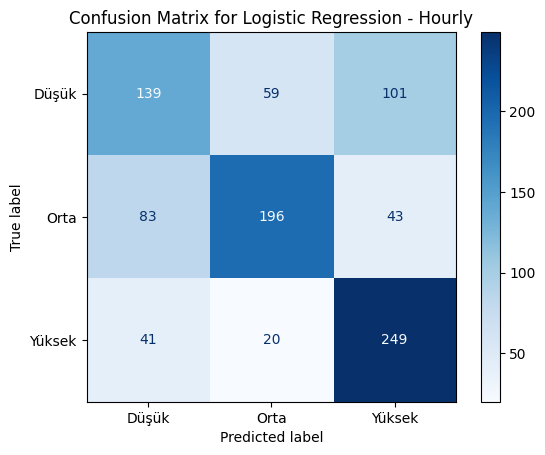


--------------------------------------------------

Model: Support Vector Machine
Accuracy for Support Vector Machine: 0.62
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

       Düşük       0.50      0.51      0.50       299
        Orta       0.72      0.57      0.64       322
      Yüksek       0.65      0.77      0.70       310

    accuracy                           0.62       931
   macro avg       0.62      0.62      0.62       931
weighted avg       0.63      0.62      0.62       931



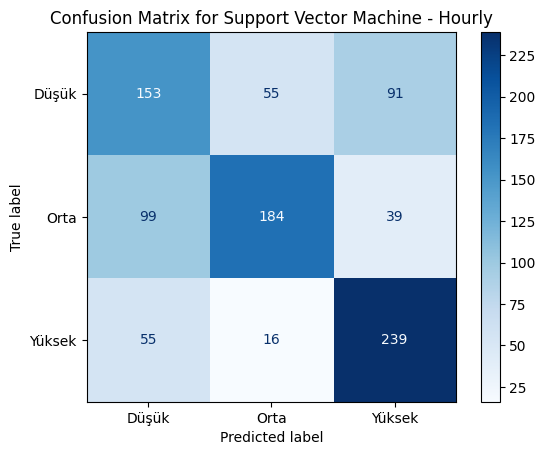


--------------------------------------------------

Model: Random Forest
Accuracy for Random Forest: 0.73
Classification Report for Random Forest:
              precision    recall  f1-score   support

       Düşük       0.64      0.66      0.65       299
        Orta       0.82      0.60      0.69       322
      Yüksek       0.74      0.93      0.83       310

    accuracy                           0.73       931
   macro avg       0.73      0.73      0.72       931
weighted avg       0.74      0.73      0.72       931



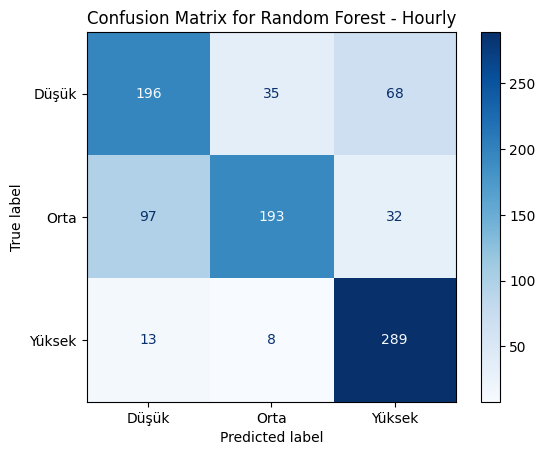


--------------------------------------------------



In [184]:

X = hourly_df.drop(['price_value', 'Level', 'price_category'], axis=1)
y = hourly_df['price_category']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("\nHOURLY RATE PERFORMANCE METRICS:\n" + "-" * 40)

for name, model in models.items():
    print(f"Model: {name}")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    hourly_accuracy.append(accuracy)
    print(f"Accuracy for {name}: {accuracy:.2f}")

    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix for {name} - Hourly")
    plt.show()
    print("\n" + "-"*50 + "\n")

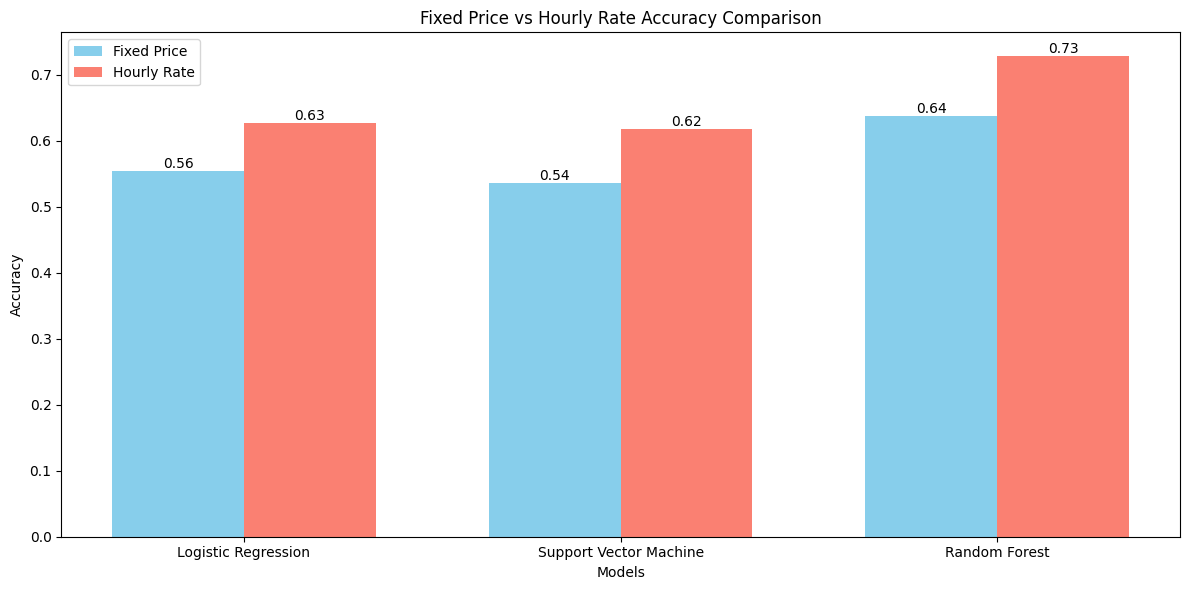

In [185]:
"""
Her df ve model için elde edilen accuracy değerlerini bir arraye kaydettim ve bir bar grafiği çizdirdim.
"""
models_names = models.keys()

# Yükseklik ayarları (barlar arasında biraz boşluk bırakmak için)
x = np.arange(len(models_names))

# Bar grafiği çizmek
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35  # Bar genişliği
bars_fixed = ax.bar(x - bar_width / 2, fixed_accuracy, bar_width, label='Fixed Price', color='skyblue')
bars_hourly = ax.bar(x + bar_width / 2, hourly_accuracy, bar_width, label='Hourly Rate', color='salmon')

# X eksenini model isimleriyle etiketle
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Fixed Price vs Hourly Rate Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models_names)

# Y legend eklemek
ax.legend()

# Barların üstünde değerleri yazma
ax.bar_label(bars_fixed, labels=[f'{x:.2f}' for x in fixed_accuracy], fontsize=10)
ax.bar_label(bars_hourly, labels=[f'{x:.2f}' for x in hourly_accuracy], fontsize=10)

# Grafik ayarları
plt.tight_layout()
plt.show()

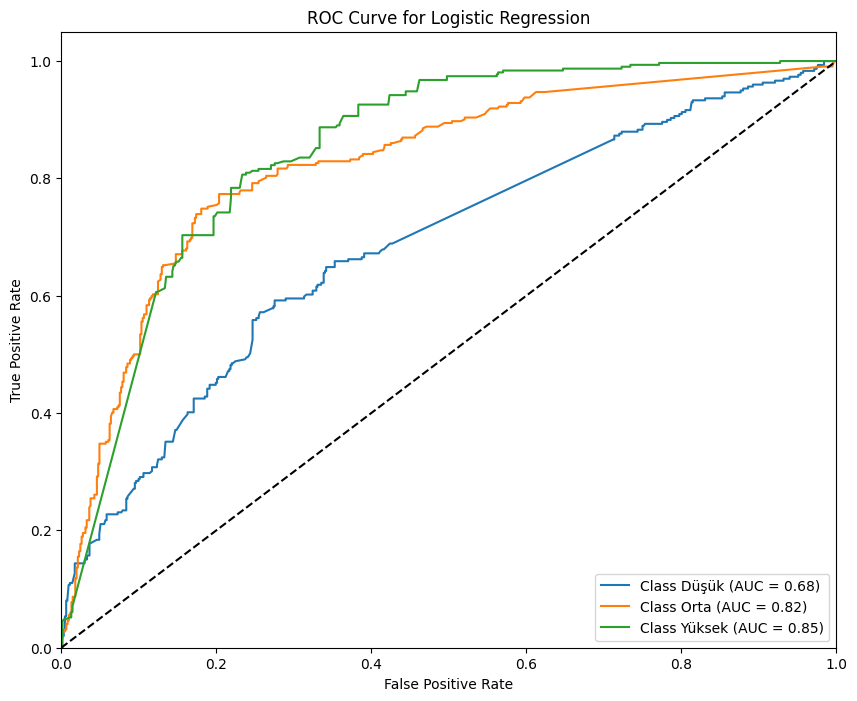

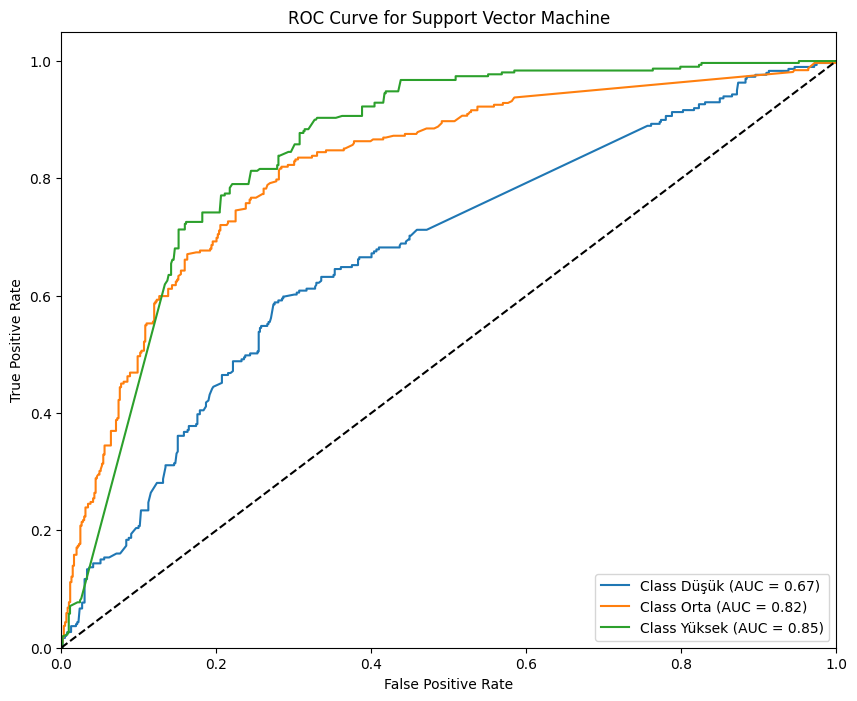

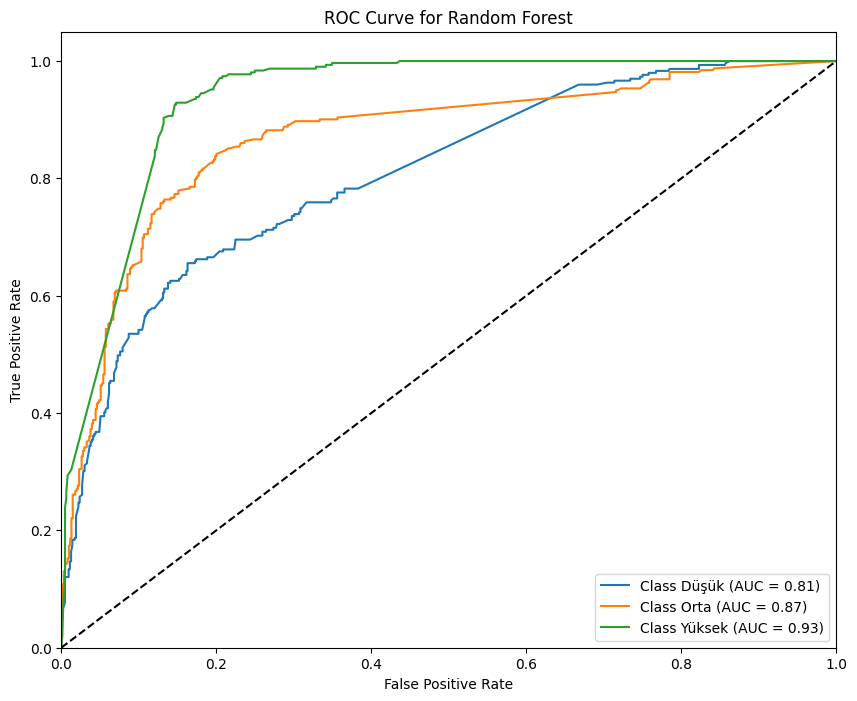

In [186]:
"""
Modellerin roc curve eğrilerini çizdirdim. y_test de 3 adet sınıf olduğu için bunları LabelBinarizer ile sınıflandırdım.
Modelin olasılıklarını aldım ve her sınıf için fpr, tpr ve auc değerlerini hesapladım.

y_test_bin[:, i]: Her bir sınıf için gerçek etiketlerin çıktıları.
y_score[:, i]: Her bir sınıf için modelin tahmin ettiği olasılık değerleri.

TPR: Doğru pozitiflerin toplam gerçek pozitiflere oranı. (TP/(TP+FN))
FPR: Yanlış pozitiflerin toplam negatif örneklere oranı. (FP/(FP+TN))

"""
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

for name, model in models.items():

    y_score = model.predict_proba(X_test)

    # ROC eğrisini çizmek için her sınıf için fpr, tpr ve auc hesaplayalım
    plt.figure(figsize=(10, 8))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f"ROC Curve for {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()